In [1]:
import pandas as pd
from preprocess import load_data_year
import seaborn as sns
import matplotlib.pyplot as plt
from analysis import aggregate_by_country
from pathlib import Path

D:\Sna project\graph.py:13: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  'alpha_3').T.to_dict('list')


In [2]:
raw_path = Path('data/raw_year')
table_path = Path('latex_tables')
aggregated_data_path = Path('data/aggregated')

In [3]:
year = 1982
raw_data_path = raw_path / f'raw_{year}.csv'

In [4]:
# Read the raw data
raw_data = pd.read_csv(raw_data_path)
raw_data.head()

,Date,Source,Target,CAMEOCode,NumEvents,NumArts,Goldstein
0,1982-01-01,AFR,CUB,195,1,2,-10.0
1,1982-01-01,AFR,GOV,112,1,9,-2.0
2,1982-01-01,AFRMED,GHA,12,1,5,-0.4
3,1982-01-01,AFRMIL,AGO,190,1,1,-10.0
4,1982-01-01,AFRMIL,AGO,192,1,1,-9.5


In [5]:
# Read aggregated data
aggregated_data = pd.read_csv(aggregated_data_path / f'aggregated_all_{year}.csv')
table = aggregated_data.head(5).to_latex(index=False)

# Data analysis
In this section we will perform a general analysis on the data

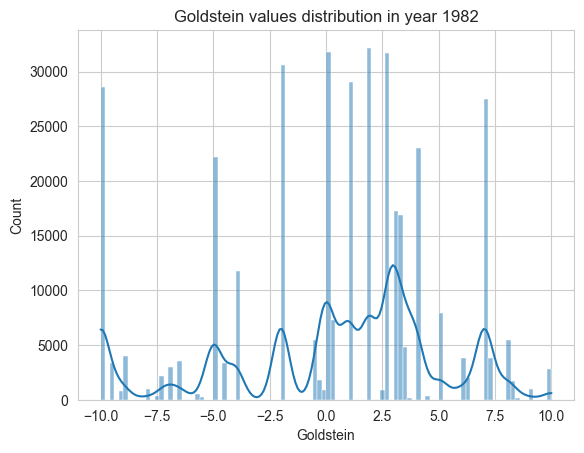

In [6]:
sources = ['USA', 'DEU', 'FRA', 'GBR', 'JPN', 'CHN', 'IND', 'BRA', 'RUS', 'IRN']
# Analyze the distribution of the goldstein values
#sns.boxplot(data=data, x='Goldstein')
# Plot goldstein values distribution
sns.histplot(raw_data, x='Goldstein', bins=100, kde=True)
plt.title(f'Goldstein values distribution in year {year}');

<Figure size 1000x500 with 0 Axes>

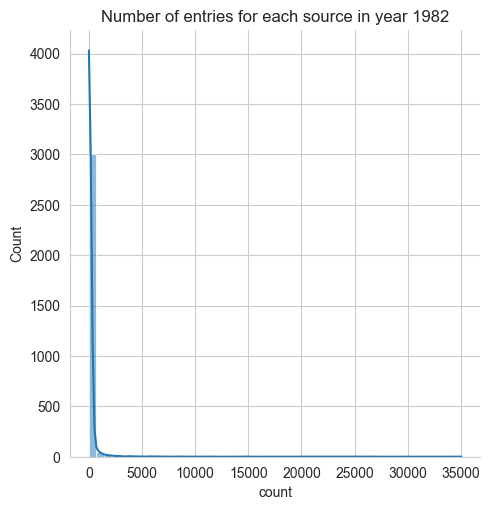

In [7]:
# Count the entries for each source
source_counts = raw_data['Source'].value_counts()
# Plot the source counts
plt.figure(figsize=(10, 5))
sns.displot(source_counts, bins=50, kde=True)
plt.title(f'Number of entries for each source in year {year}');

## Analysis on aggregated data

In [8]:
def aggregated_barplot(data, x, y, k):
    #data_aggregated = aggregate_by_country(data, x)
    k = data.sort_values(y, ascending=False).head(k)
    worst_k = data.sort_values(y, ascending=True).head(k)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(data=top_k, x=x, y=y)
    # Verical rotation of the x labels
    plt.xticks(rotation=90)
    plt.title(f'Top {k} {x} in year {year}')
    plt.subplot(1, 2, 2)
    sns.barplot(data=worst_k, x=x, y=y)
    plt.xticks(rotation=90)
    plt.title(f'Worst {k} {x} in year {year}');

In [9]:
# k = 10
# self_include = True
# data_aggregated_source = aggregate_by_country(raw_data, 'Source', self_include)
# data_aggregated_target = aggregate_by_country(raw_data, 'Target', self_include)
# aggregated_barplot(data_aggregated_source, 'Source', 'Goldstein', k)
# aggregated_barplot(data_aggregated_target, 'Target', 'Goldstein', k)

In [10]:
# data_aggregated_source_target = aggregate_by_country(raw_data, ['Source', 'Target'], self_include)
# # Make pairs aggregation
# data_aggregated_source_target['Source-Target'] = data_aggregated_source_target['Source code'] + '-' + data_aggregated_source_target['Target code']
# aggregated_barplot(data_aggregated_source_target, 'Source-Target', 'Goldstein', k)

## Centrality analysis

In [17]:
from analysis import compute_centrality, compute_page_rank
from graph import load_graph_for
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
years = [year for year in range(1979, 2015)]
centrality_measure = 'degree'
map_type = 'all'
nations = {}
for year in years:
    graph = load_graph_for(year, map_type=map_type)
    centrality, _  = compute_centrality(graph, centrality_measure)
    for node, value in centrality.items():
        nations.setdefault(node, {})
        nations[node][year] = value 

In [13]:
# Create a dataframe with the centralities
centralities = pd.DataFrame(nations).T
centralities

,1979,1980,1983,1986,1987,1989,1990,1991,1992,1993,...,2011,2012,2013,2014,1981,1982,1984,1985,1988,1994
MNG,0.027027,0.009009,0.008850,0.015748,0.017094,0.008065,0.023256,0.030534,0.015748,0.007752,...,0.023529,0.017045,0.017964,0.013333,NaN,NaN,NaN,NaN,NaN,NaN
HUN,0.135135,0.063063,0.070796,0.047244,0.051282,0.088710,0.062016,0.091603,0.078740,0.062016,...,0.076471,0.062500,0.017964,0.033333,0.027778,0.045045,0.068966,0.042735,0.063492,0.059259
MEX,0.054054,0.027027,0.115044,0.055118,0.094017,0.056452,0.015504,0.045802,0.039370,0.038760,...,0.129412,0.136364,0.101796,0.120000,0.083333,0.063063,0.068966,0.085470,0.039683,0.029630
BOL,0.027027,0.009009,0.026549,0.007874,0.017094,0.024194,0.023256,0.007634,NaN,0.015504,...,0.023529,0.039773,0.017964,0.006667,NaN,0.009009,0.008621,NaN,0.015873,0.007407
RUS,0.369369,0.450450,0.362832,0.346457,0.435897,0.362903,0.333333,0.389313,0.401575,0.403101,...,0.394118,0.403409,0.419162,0.260000,0.407407,0.315315,0.336207,0.367521,0.412698,0.422222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CYM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005882,0.011364,0.005988,0.006667,NaN,NaN,NaN,NaN,NaN,NaN
MHL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.005882,NaN,NaN,0.020000,NaN,NaN,NaN,NaN,NaN,NaN
DMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.017045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.005682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


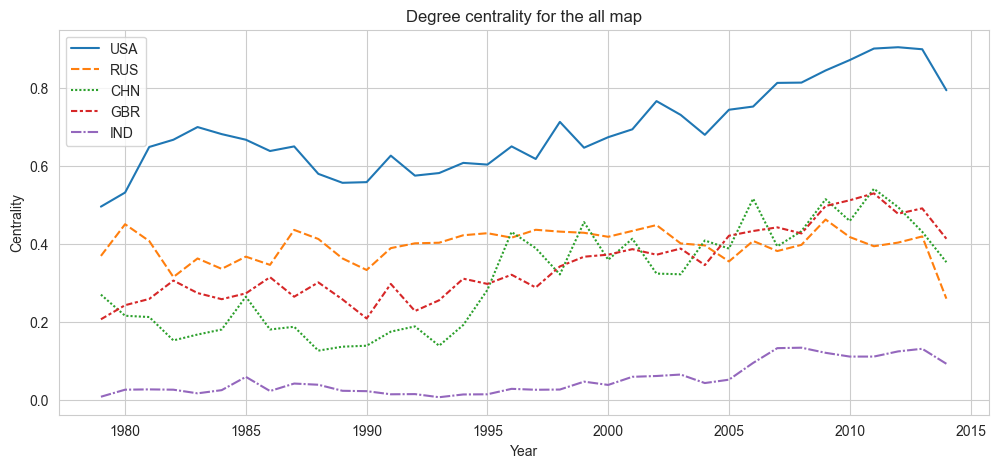

In [14]:
states = ['USA', 'RUS', 'CHN', 'GBR', 'IND'],#['USA', 'DEU', 'FRA', 'GBR', 'JPN', 'CHN', 'IND', 'BRA', 'RUS', 'IRN']
plt.figure(figsize=(12, 5))
sns.lineplot(data=centralities.loc[states].T, dashes=True)
plt.xlabel('Year')
plt.ylabel('Centrality')
plt.title(f'{centrality_measure.capitalize()} centrality for the {map_type} map')
plt.show()

In [23]:
def print_centralities(year: int, nations: list):
    for centrality_measure in ['degree', 'closeness', 'betweenness', 'eigenvector']:
        graph = load_graph_for(year, map_type=map_type)
        
        print(f'Centrality measure: {centrality_measure}')
        centrality, _  = compute_centrality(graph, centrality_measure)
        print(f'Year: {year}')
        for nation in nations:
            print(f'{nation}: {centrality[nation]:.3f}')
        
     # compute page rank
        print(f'Page rank')
        page_rank, _ = compute_page_rank(graph)
        for nation in nations:
            print(f'{nation}: {page_rank[nation]:.3f}')   
        
print_centralities(1982, ['USA', 'RUS', 'CHN', 'GBR', 'IND'])

Centrality measure: degree
Year: 1982
USA: 0.667
RUS: 0.315
CHN: 0.153
GBR: 0.306
IND: 0.027
Page rank
USA: 0.066
RUS: 0.027
CHN: 0.023
GBR: 0.036
IND: 0.004
Centrality measure: closeness
Year: 1982
USA: 0.718
RUS: 0.526
CHN: 0.481
GBR: 0.534
IND: 0.427
Page rank
USA: 0.087
RUS: 0.037
CHN: 0.018
GBR: 0.037
IND: 0.004
Centrality measure: betweenness
Year: 1982
USA: 0.656
RUS: 0.068
CHN: 0.015
GBR: 0.043
IND: 0.000
Page rank
USA: 0.087
RUS: 0.037
CHN: 0.018
GBR: 0.037
IND: 0.004
Centrality measure: eigenvector
Year: 1982
USA: 0.344
RUS: 0.095
CHN: 0.086
GBR: 0.216
IND: 0.007
Page rank
USA: 0.066
RUS: 0.027
CHN: 0.023
GBR: 0.036
IND: 0.004


In [96]:
# Create a two column dataframe with the centralities from nations
df = pd.DataFrame(nations)
df = df.reset_index()
df = pd.melt(df, id_vars='index', var_name='state', value_name='centrality')
df.rename(columns={'index': 'year'}, inplace=True)
df

,year,state,centrality
0,1979,ZWE,0.063063
1,1980,ZWE,0.072072
2,1981,ZWE,0.055556
3,1982,ZWE,0.045045
4,1983,ZWE,0.053097
...,...,...,...
6943,2010,COK,NaN
6944,2011,COK,NaN
6945,2012,COK,0.005682
6946,2013,COK,NaN


In [97]:
states = ['USA', 'RUS', 'CHN', 'GBR', 'IND']
# Take the countries that we want to analyze
top = df[df['state'].isin(states)]
# Every 5 years
top = top[top['year'] % 3 == 0]

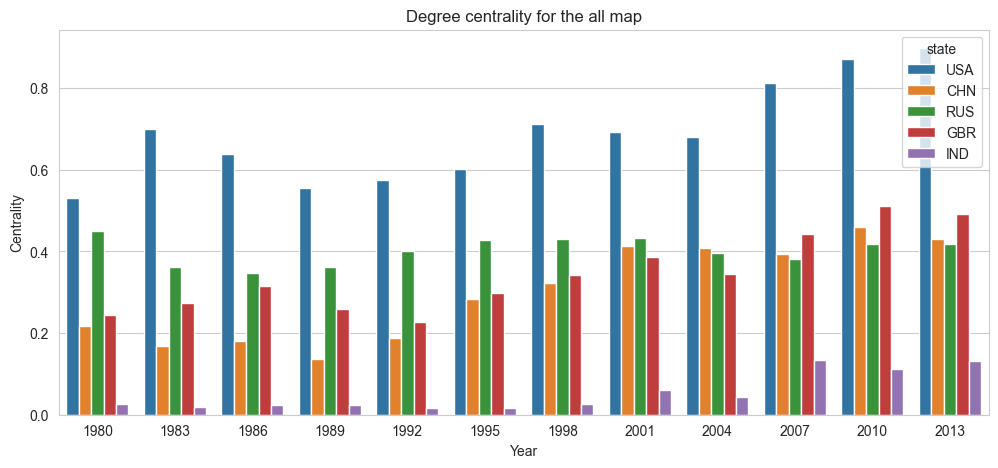

In [98]:
plt.figure(figsize=(12, 5))
sns.barplot(data=top, x='year', y='centrality', hue='state', orient='v')
plt.xlabel('Year')
plt.ylabel('Centrality')
plt.title(f'{centrality_measure.capitalize()} centrality for the {map_type} map')
plt.show()

In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Friendship and enmity analysis

In [100]:
map_type = 'all'
pairs = {}
for year in years:
    graph = load_graph_for(year, map_type=map_type)
    for edge in graph.edges.keys():
        source, target = edge
        pair_name = f'{source}-{target}'
        pairs.setdefault(pair_name, {})
        pairs[pair_name][year] = - graph.edges[edge]["weight"]  if map_type == 'only_negative' else graph.edges[edge]["weight"]
        

In [101]:
## Create a dataframe with the centralities
df_pair = pd.DataFrame(pairs).T
# Fill nan values with 0
df_pair.fillna(0, inplace=True)

# Create a two column dataframe with the centralities from nations
df_pair_noindex = pd.DataFrame(pairs)
df_pair_noindex = df_pair_noindex.reset_index()
df_pair_noindex = pd.melt(df_pair_noindex, id_vars='index', var_name='pair', value_name='weight')
df_pair_noindex.rename(columns={'index': 'year'}, inplace=True)
df_pair_noindex.fillna(0, inplace=True)
df_pair_noindex

,year,pair,weight
0,1979,ZWE-ZMB,-0.014545
1,1980,ZWE-ZMB,0.005963
2,1981,ZWE-ZMB,0.018952
3,1982,ZWE-ZMB,0.007053
4,1985,ZWE-ZMB,0.011321
...,...,...,...
140035,2012,CAF-BEN,0.000000
140036,1984,CAF-BEN,0.000000
140037,1991,CAF-BEN,0.000000
140038,1995,CAF-BEN,0.000000


In [102]:
selected_pairs = ['USA-AFG', 'USA-CHN', 'USA-GBR', 'USA-RUS', 'RUS-CHN']
#    , 'USA-IND', 'RUS-CHN', 'RUS-GBR', 'RUS-IND', 'CHN-GBR', 'CHN-IND', 'ISR-PSE']
# Take the countries that we want to analyze
top = df_pair_noindex[df_pair_noindex['pair'].isin(selected_pairs)]
# Every 5 years
top = top[top['year'] % 4 == 0]

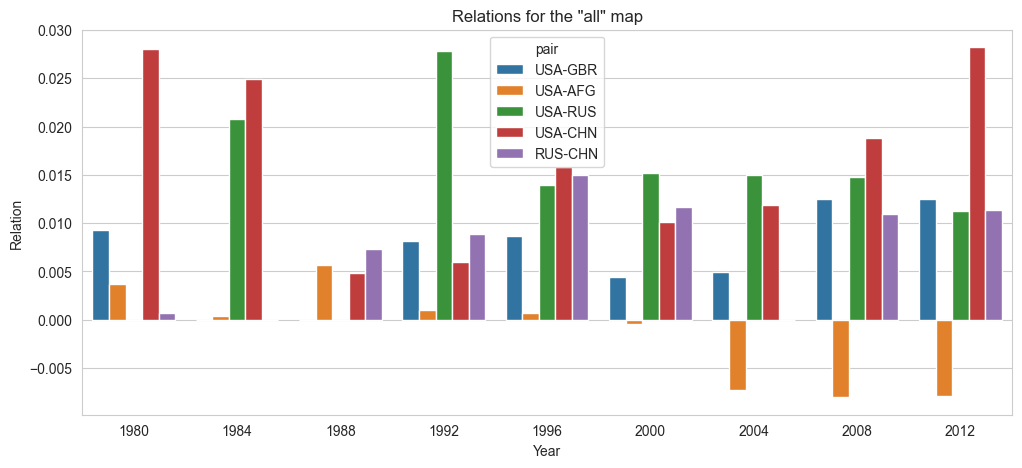

In [103]:
plt.figure(figsize=(12, 5))
sns.barplot(data=top, x='year', y='weight', hue='pair', orient='v')
plt.ylabel('Relation')
plt.xlabel('Year')
plt.title(f'Relations for the "{map_type}" map')
plt.show()

In [104]:
# Create source target pairs
selected_nations = ['USA', 'RUS', 'CHN', "ISR", "PSE", "AFG", "IRN", "IRQ"]
top_k = 10
selected_year = 1994
df_pair_noindex_st = df_pair_noindex.copy()
splitted = df_pair_noindex_st['pair'].str.split('-', n=1, expand=True)
df_pair_noindex_st['P1'] = splitted[0]
df_pair_noindex_st['P2'] = splitted[1]
df_pair_noindex_st = df_pair_noindex_st[df_pair_noindex_st['year'] == selected_year]
df_pair_noindex_st

,year,pair,weight,P1,P2
10,1994,ZWE-ZMB,0.002666,ZWE,ZMB
46,1994,ZWE-MOZ,0.000000,ZWE,MOZ
82,1994,ZWE-NAM,0.000000,ZWE,NAM
118,1994,ZWE-GBR,0.000000,ZWE,GBR
154,1994,ZWE-USA,0.000000,ZWE,USA
...,...,...,...,...,...
139870,1994,MEX-MHL,0.000000,MEX,MHL
139906,1994,MEX-TWN,0.000000,MEX,TWN
139942,1994,MHL-SLV,0.000000,MHL,SLV
139978,1994,CAF-SSD,0.000000,CAF,SSD


In [105]:
import plotly.graph_objects as go

In [106]:
def plot_pairs(df, k, title='Worst'):
    # Plot the worst pairs
    fig = go.Figure()
    # Take the first element for each year
    
    for i in range(k):
        values = []
        pairs = []
        for year in df['year'].unique():
            data = df[df['year'] == year]
            data = data.reset_index()
            values.append(data['weight'].iloc[i])
            pairs.append(data['pair'].iloc[i])
        fig.add_trace(go.Bar(x=df['year'].unique(), y=values, text=pairs))
    # Hide the legend
    fig.update_layout(barmode='group', xaxis={'categoryorder':'array', 'categoryarray':years}, showlegend=False)
    # Set the title
    fig.update_layout(title=f'{title} {k} pairs for each year')
    # Set labels
    fig.update_xaxes(title_text='Year')
    fig.update_yaxes(title_text='Weight')
    fig.show()


In [107]:
# For each year we select the worse 10 pairs
k = 3
# Take every 5 years
worst_pairs = df_pair_noindex[df_pair_noindex['year'] % 5 == 0]
worst_pairs = worst_pairs.groupby('year').apply(lambda x: x.nsmallest(k, 'weight'))
worst_pairs = worst_pairs.reset_index(drop=True)
# Sort by year
worst_pairs = worst_pairs.sort_values('year')
# Plot the worst pairs  
plot_pairs(worst_pairs, k, title='Worst')

# Top pairs
top_pairs = df_pair_noindex[df_pair_noindex['year'] % 5 == 0]
top_pairs = top_pairs.groupby('year').apply(lambda x: x.nlargest(k, 'weight'))
top_pairs = top_pairs.reset_index(drop=True)
# Sort by year
top_pairs = top_pairs.sort_values('year')
# Plot the worst pairs
plot_pairs(top_pairs, k, title='Top')


C:\Users\Matteo\AppData\Local\Temp\ipykernel_9132\540833673.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



C:\Users\Matteo\AppData\Local\Temp\ipykernel_9132\540833673.py:14: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

